## NLP exploration on plot summaries

In [1]:
# Import the needed libarairies
import warnings # to ignore pandas version warning
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator
from scipy.stats import ttest_ind, spearmanr # to implement statistical tests
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans # for actors analysis
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from itertools import zip_longest # to iterate over many lists at the same time

############# NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim
import pyLDAvis.gensim_models
import vaderSentiment # Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
########################### Read datasets from repository's data folder ############################
movie_mtd = pd.read_table('data/movie_metadata_CMU_IMDB.csv', sep=',')
actor_mtd = pd.read_table('data/actor_metadata_CMU.csv', sep=',')
personas_mtd = pd.read_table('data/personas_metadata_CMU.csv', sep=',')

plot_summaries_df = pd.read_csv('data/plot_summaries_CMU.csv', sep = ',', usecols= ['ID', 'Summary'])

In [33]:
# Set a global background theme for all our plots and ignore warnings
sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

### Subdataset creation to faciliates the analysis

In [3]:
# Creating deep copies of original data frame to avoid messing it up
all_movies = movie_mtd.copy() # all movies in the dataset, no matter their production country
us_movies = movie_mtd.copy() 
us_partially_movies = movie_mtd.copy()
all_us_movies = movie_mtd.copy()
rest_world_non_US = movie_mtd.copy()

## Filtering the newly created dataframes for the analysis of nox office revenue, IMDb ratings and runtimes
# Movies strictly produced in the US
us_movies = us_movies[us_movies['countries'] == 'United States of America']
# Movies partially produced in the US
us_partially_movies = us_partially_movies[(us_partially_movies['countries'].str.contains('United States of America') == True) & (us_partially_movies['countries'] != 'United States of America')]
# Contains the movies strictly produced in the US and the ones partially produced in the US
all_us_movies = all_us_movies[(all_us_movies['countries'] == 'United States of America') | (all_us_movies['countries'].str.contains('United States of America') == True)]

# Non-US movies
rest_world_non_US = rest_world_non_US[(rest_world_non_US['countries'].str.contains('United States of America') == False) & (rest_world_non_US['countries'] != 'United States of America')]

In [4]:
us_movies.head()

,wiki_movie_ID,freebase_movie_ID,title,release_date,box_office,runtime,languages,countries,genres_CMU,release_year,genres_IMDB,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001.0,"Action,Horror,Sci-Fi",4.9,58894.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenet Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000.0,NaN,NaN,NaN
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"Silent film, English Language",United States of America,"Short Film, Silent film, Indie, Black-and-whit...",1913.0,"Comedy,Short",7.2,19.0
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,English Language,United States of America,"Musical, Comedy, Black-and-white",1938.0,"Drama,Music,Musical",6.8,2357.0
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,English Language,United States of America,"Drama, Black-and-white",1930.0,"Drama,Romance",5.4,356.0


### Opening of the Plot summaries dataset

In [5]:
# Increase the display width to see more characters per column
pd.set_option('display.max_colwidth', None)  # This removes the column width limit

# Display the first 3 lines of each summary in the 'Summary' column
plot_summaries_df['Preview'] = plot_summaries_df['Summary'].apply(lambda x: ' '.join(x.split()[:50])) # x.split() splits the text into individual words, .join rebuilds the string after
# splitlines() to split into separate lines if the text already contains line breaks

# Show the first few rows with the Preview column
plot_summaries_df[['ID', 'Preview']].head()

# sort the plot summaries according to the Wikipedia movie ID
plot_summaries_df_sorted = plot_summaries_df.sort_values(ascending = True , by= 'ID')
plot_summaries_df_sorted[['ID', 'Preview']].head()

print(f"The size of the plot summaries dataset is {plot_summaries_df.shape}.")

plot_summaries_df.head()

The size of the plot summaries dataset is (42303, 3).


ID  \
0  23890098   
1  31186339   
2  20663735   
3   2231378   
4    595909   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Merging the plot summaries dataset with the movie_mmtd dataset in order to distinguish between US-only. partially US and non US produced movies

In [6]:
# Performing inner joins to be sure each movie kept after the merge has a plot summaries and filtering to keep only useful columnbs for the rest of the analysis
plot_summaries_all_movies = pd.merge(plot_summaries_df, all_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['ID', 'Summary','title', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)
#.drop(columns= ['Preview', 'wiki_movie_ID', 'freebase_movie_ID', 'release_date', 'runtime', 'countries', 'genres_CMU'], inplace= True)

plot_summaries_us_movies = pd.merge(plot_summaries_df, us_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['ID', 'Summary', 'title', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_us_partially_movies = pd.merge(plot_summaries_df, us_partially_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['ID', 'Summary', 'title', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_RoW_movies = pd.merge(plot_summaries_df, rest_world_non_US, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['ID', 'Summary', 'title', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

print(f"The size of the plot summaries dataframe merged with the dataset containing all the movies metadata is {plot_summaries_all_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing US-only produced movies is {plot_summaries_us_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing all the partially US-produced movies is {plot_summaries_us_partially_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing all Non US-produced movies is {plot_summaries_RoW_movies.shape}.")

plot_summaries_us_movies.head()

The size of the plot summaries dataframe merged with the dataset containing all the movies metadata is (42208, 8).
The size of the plot summaries dataframe merged with the dataset containing US-only produced movies is (17776, 8).
The size of the plot summaries dataframe merged with the dataset containing all the partially US-produced movies is (3015, 8).
The size of the plot summaries dataframe merged with the dataset containing all Non US-produced movies is (18105, 8).


ID  \
0  31186339   
1   2231378   
2   1952976   
3  24225279   
4   2462689   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Basics stats on the plot summaries

In [ ]:
# Whole dataset
basic_stats_numwords_plotsSummaries_all_movies = plot_summaries_all_movies['Summary'].apply(lambda x: len(str(x).split()))
# American movies STRICTLY produced in the US
#basic_stats_numwords_plotsSummaries_US = us_movies['Summary'].describe()
# American movies PARTIALLY produced in the US
# basic_stats_numwords_plotsSummaries_US_partial = us_partially_movies['box_office'].describe()
# # Rest of world (= Non Us movies)
# basic_stats_numwords_plotsSummaries_ROW = rest_world_non_US['box_office'].describe()

# dict_results = {'All movies': [basic_stats_box_office_all_movies.loc['50%'], basic_stats_box_office_all_movies.loc['mean'], basic_stats_box_office_all_movies.loc['std'], basic_stats_box_office_all_movies.loc['max'], basic_stats_box_office_all_movies.loc['min']], 
#                 'US-only produced': [basic_stats_box_office_US.loc['50%'], basic_stats_box_office_US.loc['mean'], basic_stats_box_office_US.loc['std'], basic_stats_box_office_US.loc['max'], basic_stats_box_office_US.loc['min']], 
#                 'Partially US-produced': [basic_stats_box_office_US_partial.loc['50%'], basic_stats_box_office_US_partial.loc['mean'], basic_stats_box_office_US_partial.loc['std'], basic_stats_box_office_US_partial.loc['max'], basic_stats_box_office_all_movies.loc['min']],
#                 'Non US produced (ROW)': [basic_stats_box_office_ROW.loc['50%'], basic_stats_box_office_ROW.loc['mean'], basic_stats_box_office_ROW.loc['std'], basic_stats_box_office_ROW.loc['max'], basic_stats_box_office_ROW.loc['min']]}

# df_basic_stat_box_office = pd.DataFrame(dict_results, index = ['median (millions USD)', 'mean (millions USD)', 'std (millions USD)', 'max (millions USD)', 'min (millions USD)'])/1e6
# # To display only 2 decimals after the comma taking advantage of the Jupyter notebook environment
# df_basic_stat_box_office.style.format("{:.2f}") 

from collections import Counter
# with stopwords and ponctuation
words = [token.text for token in doc]
word_freq = Counter(words)
common_words = word_freq.most_common() # five most common tokens
# without stopwords and ponctuation
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
word_freq = Counter(words)
common_words = word_freq.most_common()

KeyError: 'Summary'

In [14]:
def word_counter(df, lower_bound=1, upper_bound=20): #setting default lower and upper bounds value
    """
    Function that counts the number of plot summaries with word counts 
    within specified bounds.

    Params:
        df (pd.DataFrame): DataFrame containing a column 'Summary'.
        lower_bound (int, optional): Minimum number of words in a plot summary (exclusive).
                                     Use None to apply no lower bound. Default is 1.
        upper_bound (int, optional): Maximum number of words in a plot summary (inclusive).
                                     Default is 20.
    Returns: The count of summaries within the specified word count range (int).
    """
    if 'Summary' not in df.columns:
        raise ValueError("The dataframe must have a column named 'Summary'.")

    # Precompute word counts for efficiency
    word_counts = df['Summary'].apply(lambda x: len(str(x).split()))

    if lower_bound is None:
        # Apply only the upper bound
        return word_counts[word_counts >= upper_bound].count()
    else:
        # Apply both lower and upper bounds
        return word_counts[(word_counts > lower_bound) & (word_counts <= upper_bound)].count()

# Initializing the need lists and dictionnary
list_name_df = ['All movies', 'US-only produced movies', 'Partially US-produced movies', 'Non US-produced movies']
list_df_plot_summaries = [plot_summaries_all_movies, plot_summaries_us_movies, plot_summaries_us_partially_movies, plot_summaries_RoW_movies]
list_set_number_words = [[1, 20], [20, 100], [100, 300], [300,500], [500, 1000], [1000, 2000], [2000, 3000]]
dict_plot_count = {'All movies': [], 'US-only produced movies': [], 
                   'Partially US-produced movies': [], 'Non US-produced movies': [], 
                   }

# Use of "zip" will make the loop terminates when the shortest iterable is exhausted so one put it in the second for loop to make sure all the 7 words count interval are processed
dict_plot_count = {name: [] for name in list_name_df}
interval_names = [f"{low}-{high}" for low, high in list_set_number_words]

for interval in list_set_number_words:
    for df, dico_name in zip(list_df_plot_summaries, list_name_df):
        word_count = word_counter(df, lower_bound = interval[0], upper_bound = interval[1])
        dict_plot_count[dico_name].append(word_count)

# Create DataFrame with interval names as index and title
df_count_plot_summaries = pd.DataFrame(dict_plot_count, index=interval_names)

# Add a title for the rows as an index
df_count_plot_summaries.index.name = "Word number Interval"

# Compute the total number of plot summaries for each columns and add it as the last row of the df
df_count_plot_summaries.loc["Total"] = df_count_plot_summaries.sum(axis=0)

print("The below table shows the number of plot summaries satisfying the number of word range (rows of the displayed dataframe)")
df_count_plot_summaries.head(8)


The below table shows the number of plot summaries satisfying the number of word range (rows of the displayed dataframe)


,All movies,US-only produced movies,Partially US-produced movies,Non US-produced movies
Word number Interval,,,,
1-20,397,133,11,180
20-100,12137,4639,531,5662
100-300,14406,5600,702,6905
300-500,5933,2745,450,2392
500-1000,7867,3973,1073,2501
1000-2000,1381,658,235,428
2000-3000,69,25,10,29
Total,42190,17773,3012,18097


One notices first that most of the plot summaries show a number of words between 100 and 300. Next, come the plots having 20-100 words intheir summaries. One sees that they are very few plots summaries with more than 2000 words. Finally, one sees that with those word intervals one captures nearly all the movies. Indeed, th column *total* for all the movies shows 42190 movies out of 42208 (see above cell) meaning that only 18 plots summarie shave more than 3000 words. One observe similar behavior for the US-only produced, Partially US-produced and Non Us-produced movies.

Visualization

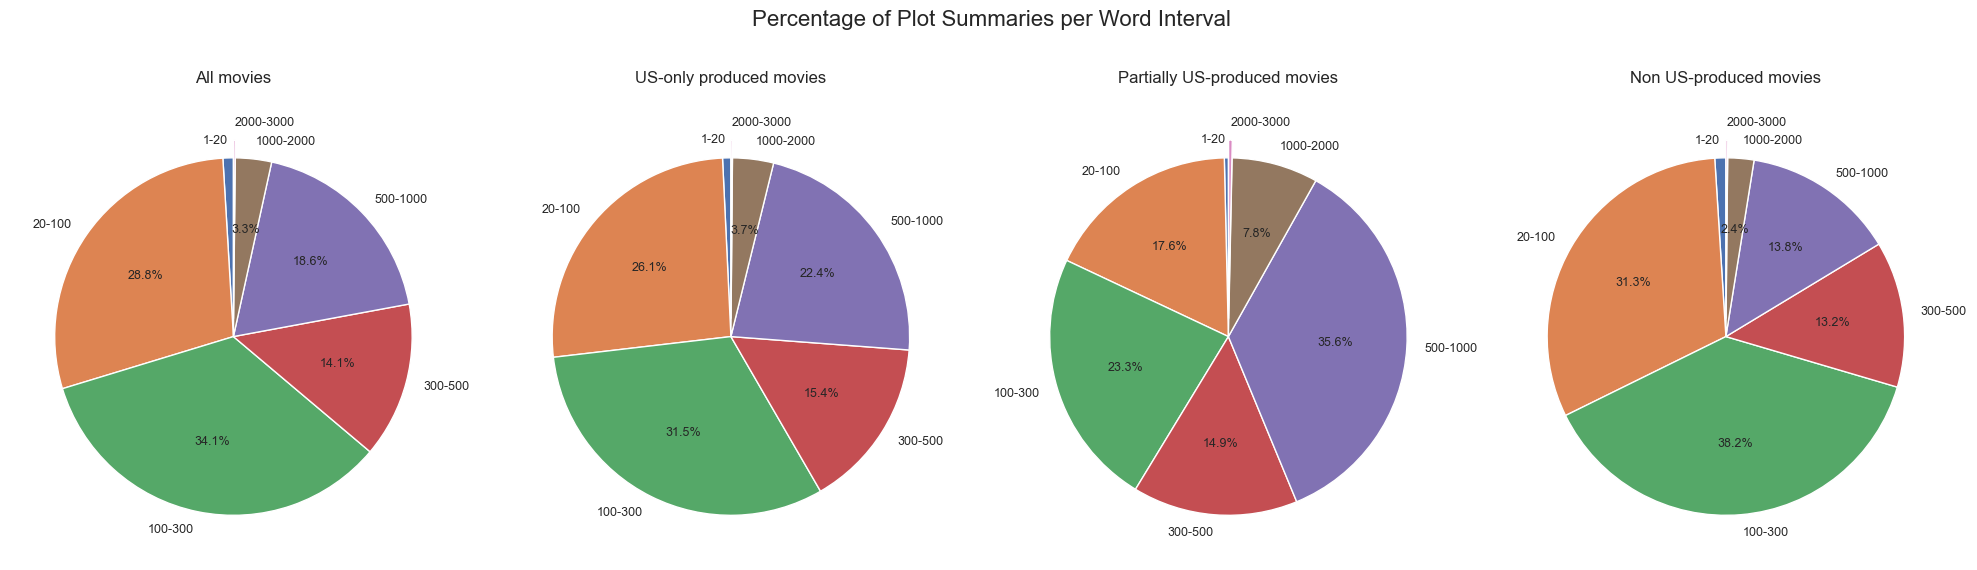

In [60]:
colors = sns.color_palette("pastel", len(df_count_plot_summaries.index))

def autopct_threshold(pct):
    return f'{pct:.1f}%' if pct > 1 else ''  # Only display if percentage > 1%

plots = df_count_plot_summaries.iloc[:-1].plot.pie(
    subplots=True,
    figsize=(20, 8),
    title= False,
    legend=False,
    autopct=autopct_threshold,
    explode=(0, 0, 0, 0, 0, 0, 0.1),
    shadow=False,
    startangle=90,
    textprops={'fontsize': 9},
    color = colors
)

# Manually set the titles above the charts
titles = df_count_plot_summaries.columns
for ax, title in zip(plots, titles):
    ax.set_title(title, fontsize=12, y=1.05)  # Adjust y to move title above
    ax.set_ylabel('')  # Remove the default title on the left

# Global adjustments
plt.suptitle("Percentage of Plot Summaries per Word Interval", fontsize=16)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])
plt.show()

In [ ]:
# # Calculate the mean number of words per summary
# mean_number_words_per_summary = plot_summaries_df['word_count'].mean()

# # Count the number of words in each summary using len(x.split()) directly
# plot_summaries_df['word_count'] = plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) # count words in a string by splitting on spaces 8by default)

# number_summaries_more_500_words = plot_summaries_df[plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) >= 500]['Summary'].count()
# number_summaries_more_1000_words = plot_summaries_df[plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) >= 1000]['Summary'].count()
# number_summaries_more_3000_words = plot_summaries_df[plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) > 3000]['Summary'].count()


# print(f"Mean number of words per summary: {mean_number_words_per_summary:.2f}")

# print(f"The number of plot summaries with more than 500 words is {number_summaries_more_500_words}.")
# print(f"The number of plot summaries with more than 1000 words is {number_summaries_more_1000_words}.")
# print(f"The number of plot summaries with more than 3000 words is {number_summaries_more_3000_words}.")

### NLP

In [ ]:
# Initialize the Spacy analyzer in English
nlp = spacy.load('en_core_web_sm')

# Semantic analysis based on lexical categories

from empath import Empath
lexicon = Empath()

# pre-build categores
for cat in list(lexicon.cats.keys())[:15]:
    print(cat) # returns words linked with cat 

# examine representative terms for each category
lexicon.cats["health"][:15]

# analyse a whole book
empath_features = lexicon.analyze(doc.text,categories = ["disappointment", "pain", "joy", "beauty", "affection"]) # returns the number of each specified categories features in the book

# create ustom categories
lexicon.create_category("healthy_food", ["healthy_food","low_carb","kale","avocado"], model="nytimes") # model = "nytimes" (New York Times), "fiction"or "reddit"
